# BERT Fine-Tuning

In [31]:
from google.colab import files
uploaded = files.upload()

Saving train.tsv to train (1).tsv


In [32]:
import pandas

dataset = pandas.read_csv('train.tsv', delimiter = "\t", index_col="id", nrows=5000)
dataset.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1
50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1
50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1
61,123,124,Is it normal to have a dark ring around the ir...,What causes a dark ring around the iris? How s...,0
98,197,198,What are the best associate product manager (A...,What are the general requirement to become a P...,0


Let's see what we got:

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 31 to 333474
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          5000 non-null   int64 
 1   qid2          5000 non-null   int64 
 2   question1     5000 non-null   object
 3   question2     5000 non-null   object
 4   is_duplicate  5000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 234.4+ KB


# Tokenizing


In [34]:
#!pip install transformers
!pip install transformers~=2.11.0
import transformers

In [35]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Split a sentence into tokens:

In [36]:
print(f"Original: {dataset['question1'].iloc[0]}")
print(f"Tokenized: {tokenizer.tokenize(dataset['question1'].iloc[0])}")
print(f"Token IDs: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dataset['question1'].iloc[0]))}")

Original: What are some special cares for someone with a nose that gets stuffy during the night?
Tokenized: ['what', 'are', 'some', 'special', 'cares', 'for', 'someone', 'with', 'a', 'nose', 'that', 'gets', 'stuff', '##y', 'during', 'the', 'night', '?']
Token IDs: [2054, 2024, 2070, 2569, 14977, 2005, 2619, 2007, 1037, 4451, 2008, 4152, 4933, 2100, 2076, 1996, 2305, 1029]


In [37]:
print(f"Original: {dataset['question2'].iloc[0]}")
print(f"Tokenized: {tokenizer.encode(dataset['question2'].iloc[0])}")

Original: How can I keep my nose from getting stuffy at night?
Tokenized: [101, 2129, 2064, 1045, 2562, 2026, 4451, 2013, 2893, 4933, 2100, 2012, 2305, 1029, 102]


In [38]:
tokenizer.decode([101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102])

'[CLS] what is the step by step guide to invest in share market? [SEP]'

## Special Tokens


In [39]:
encoded_pair = tokenizer.encode(dataset['question1'].iloc[0], dataset['question2'].iloc[0])
tokenizer.decode(encoded_pair)

'[CLS] what are some special cares for someone with a nose that gets stuffy during the night? [SEP] how can i keep my nose from getting stuffy at night? [SEP]'

## Sentence Length


In [40]:
from tqdm import tqdm



tqdm.pandas()
dataset["question1_length"] = dataset["question1"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
dataset["question2_length"] = dataset["question2"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
dataset["joint_length"] = dataset["question1_length"] + dataset["question2_length"]
dataset["joint_length"].max()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


  0%|          | 0/5000 [00:00<?, ?it/s]

 23%|██▎       | 1149/5000 [00:00<00:00, 11487.44it/s]

 57%|█████▋    | 2839/5000 [00:00<00:00, 12706.45it/s]

100%|██████████| 5000/5000 [00:00<00:00, 14103.49it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

 43%|████▎     | 2151/5000 [00:00<00:00, 21503.41it/s]

100%|██████████| 5000/5000 [00:00<00:00, 20012.88it/s]


107


# Training & Validation Split


In [41]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(dataset[["question1", "question2"]], 
                                                    dataset["is_duplicate"], test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.head()

,question1,question2
id,,
224450,What is the scope of medical microbiology?,Does medical microbiology have a good scope?
132744,What is best treatment of pancreatitis?,What is the best treatment of diabetes?
242425,Which medical insurance company has the best r...,Should I include my research abstract in my co...
169829,"Why do people think about ""what others will th...",Why do we care for others' opinion and about w...
138281,How should one remove old blade cut marks from...,How do I remove old blade cut marks from hand ...


In [42]:
y_train.head()

id
224450    0
132744    0
242425    0
169829    1
138281    1
Name: is_duplicate, dtype: int64

# Tokenize Dataset and Create Dataloader



In [43]:
max_length = 310
tokenizer.encode_plus(X_train.iloc[0]["question1"], X_train.iloc[0]["question2"], max_length=max_length, 
                      pad_to_max_length=True, return_attention_mask=True, return_tensors='pt', truncation=True)

{'input_ids': tensor([[  101,  2054,  2003,  1996,  9531,  1997,  2966, 12702, 21685,  1029,
           102,  2515,  2966, 12702, 21685,  2031,  1037,  2204,  9531,  1029,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [44]:
import torch

from tqdm import tqdm
from torch.utils.data import TensorDataset



def convert_to_dataset_torch(data: pandas.DataFrame, labels: pandas.Series) -> TensorDataset:
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        encoded_dict = tokenizer.encode_plus(row["question1"], row["question2"], max_length=max_length, pad_to_max_length=True, 
                      return_attention_mask=True, return_tensors='pt', truncation=True)

        input_ids.append(encoded_dict['input_ids'])
        token_type_ids.append(encoded_dict["token_type_ids"])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)
    
    return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

In [45]:
train = convert_to_dataset_torch(X_train, y_train)
validation = convert_to_dataset_torch(X_validation, y_validation)



  0%|          | 0/3200 [00:00<?, ?it/s]

  3%|▎         | 107/3200 [00:00<00:02, 1067.01it/s]

  7%|▋         | 234/3200 [00:00<00:02, 1120.63it/s]

 12%|█▏        | 390/3200 [00:00<00:02, 1222.73it/s]

 17%|█▋        | 534/3200 [00:00<00:02, 1279.58it/s]

 21%|██        | 677/3200 [00:00<00:01, 1320.29it/s]

 26%|██▋       | 843/3200 [00:00<00:01, 1405.88it/s]

 32%|███▏      | 1012/3200 [00:00<00:01, 1479.81it/s]

 37%|███▋      | 1177/3200 [00:00<00:01, 1526.66it/s]

 41%|████▏     | 1327/3200 [00:00<00:01, 1517.28it/s]

 46%|████▌     | 1477/3200 [00:01<00:01, 1451.29it/s]

 51%|█████     | 1622/3200 [00:01<00:01, 1406.82it/s]

 55%|█████▌    | 1763/3200 [00:01<00:01, 1406.07it/s]

 60%|█████▉    | 1915/3200 [00:01<00:00, 1437.93it/s]

 65%|██████▍   | 2077/3200 [00:01<00:00, 1487.55it/s]

 70%|██████▉   | 2227/3200 [00:01<00:00, 1486.93it/s]

 74%|███████▍  | 2376/3200 [00:01<00:00, 1423.27it/s]

 79%|███████▉  | 2520/3200 [00:01<00:00, 1417.81it/s]

 83%|████████▎ | 2663/3200 

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory:

In [46]:
import multiprocessing

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

core_number = multiprocessing.cpu_count()

train_dataloader = DataLoader(
            train,  # The training samples.
            sampler = RandomSampler(train), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=0
        )

validation_dataloader = DataLoader(
            validation, # The validation samples.
            sampler = SequentialSampler(validation), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.

            num_workers=0
        )

# Trainig the Classification Model

## BertForSequenceClassification


In [1]:
from transformers import BertForSequenceClassification



bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2, # The number of output labels--2 for binary classification.
  
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

C:\Users\12035_\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\12035_\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\12035_\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Optimizer & Learning Rate Scheduler


In [48]:
from transformers import AdamW



adamw_optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [49]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(adamw_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Training Loop


In [50]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

This method is to train one batch over our model:

In [51]:
def fit_batch(dataloader, model, optimizer, epoch):
    total_train_loss = 0
    
    for batch in tqdm(dataloader, desc=f"Training epoch:{epoch}", unit="batch"):
        input_ids, attention_masks, token_type_ids, labels = batch
        
        model.zero_grad()
        
        loss, _ = model(input_ids, 
                             token_type_ids=token_type_ids, 
                             attention_mask=attention_masks, 
                             labels=labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
        
    return total_train_loss

This method is evalute one batch over our model. We're going to use scikit learn [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html):

In [52]:
import numpy

from sklearn.metrics import accuracy_score




def eval_batch(dataloader, model, metric=accuracy_score):
    total_eval_accuracy = 0
    total_eval_loss = 0
    predictions , predicted_labels = [], []
    
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        # Unpack batch from dataloader.
        input_ids, attention_masks, token_type_ids, labels = batch
        
        with torch.no_grad():
            loss, logits = model(input_ids, 
                                   token_type_ids=token_type_ids, 
                                   attention_mask=attention_masks,
                                   labels=labels)
            #output = model(input_ids, token_type_ids=token_type_ids,attention_mask=attention_masks,labels=labels)
            #loss = output.loss
            #logits = output.logits



        total_eval_loss += loss.item()
        
        y_pred = numpy.argmax(logits.detach().numpy(), axis=1).flatten()
        total_eval_accuracy += metric(labels, y_pred)
        
        predictions.extend(logits.detach().numpy().tolist())
        predicted_labels.extend(y_pred.tolist())
    
    return total_eval_accuracy, total_eval_loss, predictions ,predicted_labels

Main loop method:

In [53]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
numpy.random.seed(seed_val)
torch.manual_seed(seed_val)


def train(train_dataloader, validation_dataloader, model, optimizer, epochs):
    training_stats = []
    
    total_t0 = time.time()
    
    for epoch in range(0, epochs):
        
        t0 = time.time()
        
        total_train_loss = 0
        
        model.train()
        
        total_train_loss = fit_batch(train_dataloader, model, optimizer, epoch)
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        
        t0 = time.time()
        
        model.eval()
        
        total_eval_accuracy, total_eval_loss, _, _ = eval_batch(validation_dataloader, model)
        
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        
        print(f"  Accuracy: {avg_val_accuracy}")
    
        avg_val_loss = total_eval_loss / len(validation_dataloader)
    
        validation_time = format_time(time.time() - t0)
    
        print(f"  Validation Loss: {avg_val_loss}")
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        

    print("")
    print("Training complete!")

    print(f"Total training took {format_time(time.time()-total_t0)}")
    return training_stats

We’re ready to kick off the training:

In [54]:
training_stats = train(train_dataloader, validation_dataloader, bert_model, adamw_optimizer, epochs)



Training epoch:0:   0%|          | 0/200 [00:00<?, ?batch/s]

Training epoch:0:   0%|          | 1/200 [00:53<2:58:12, 53.73s/batch]

Training epoch:0:   1%|          | 2/200 [01:44<2:54:41, 52.94s/batch]

Training epoch:0:   2%|▏         | 3/200 [02:36<2:52:26, 52.52s/batch]

Training epoch:0:   2%|▏         | 4/200 [03:27<2:49:51, 52.00s/batch]

Training epoch:0:   2%|▎         | 5/200 [04:18<2:47:57, 51.68s/batch]

Training epoch:0:   3%|▎         | 6/200 [05:08<2:46:08, 51.39s/batch]

Training epoch:0:   4%|▎         | 7/200 [05:59<2:45:02, 51.31s/batch]

Training epoch:0:   4%|▍         | 8/200 [06:50<2:43:43, 51.17s/batch]

Training epoch:0:   4%|▍         | 9/200 [07:41<2:42:55, 51.18s/batch]

Training epoch:0:   5%|▌         | 10/200 [08:32<2:41:45, 51.08s/batch]

Training epoch:0:   6%|▌         | 11/200 [09:28<2:44:52, 52.34s/batch]

Training epoch:0:   6%|▌         | 12/200 [10:20<2:43:53, 52.31s/batch]

Training epoch:0:   6%|▋         | 13/200 [11:10<2:41:24, 51.79s/batc

  Accuracy: 0.895
  Validation Loss: 0.26888024136424066




Training epoch:1:   0%|          | 1/200 [00:56<3:07:55, 56.66s/batch]

Training epoch:1:   1%|          | 2/200 [01:47<3:01:06, 54.88s/batch]

Training epoch:1:   2%|▏         | 3/200 [02:38<2:56:09, 53.65s/batch]

Training epoch:1:   2%|▏         | 4/200 [03:29<2:52:31, 52.82s/batch]

Training epoch:1:   2%|▎         | 5/200 [04:19<2:49:39, 52.20s/batch]

Training epoch:1:   3%|▎         | 6/200 [05:10<2:47:23, 51.77s/batch]

Training epoch:1:   4%|▎         | 7/200 [06:01<2:45:29, 51.45s/batch]

Training epoch:1:   4%|▍         | 8/200 [06:52<2:44:04, 51.27s/batch]

Training epoch:1:   4%|▍         | 9/200 [07:42<2:42:45, 51.13s/batch]

Training epoch:1:   5%|▌         | 10/200 [08:33<2:41:32, 51.01s/batch]

Training epoch:1:   6%|▌         | 11/200 [09:24<2:40:39, 51.00s/batch]

Training epoch:1:   6%|▌         | 12/200 [10:15<2:39:37, 50.94s/batch]

Training epoch:1:   6%|▋         | 13/200 [11:09<2:41:14, 51.74s/batch]

Training epoch:1:   7%|▋         | 14/200 [11:59<2:39:36, 

  Accuracy: 0.89625
  Validation Loss: 0.2777453856170177

Training complete!
Total training took 6:10:57


Let’s view the summary of the training process:

In [55]:
df_stats = pandas.DataFrame(training_stats).set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
0,0.419501,0.268880,0.89500,2:51:25,0:13:48
1,0.194195,0.277745,0.89625,2:51:57,0:13:47


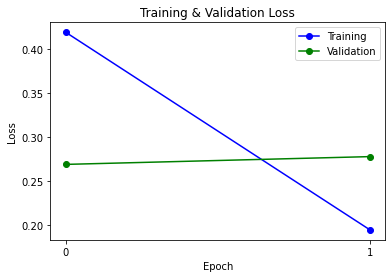

In [56]:
from matplotlib import pyplot

%matplotlib inline



pyplot.plot(df_stats['Training Loss'], 'b-o', label="Training")
pyplot.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
pyplot.title("Training & Validation Loss")
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.xticks(df_stats.index.values.tolist())
pyplot.show()

# Performance On Test Set
## Data Preparation

In [57]:
test = convert_to_dataset_torch(X_test, y_test)
test_dataloader = DataLoader(test,  sampler=SequentialSampler(test), batch_size=batch_size)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:43,  9.64it/s]

  8%|▊         | 84/1000 [00:00<01:06, 13.70it/s]

 19%|█▉        | 191/1000 [00:00<00:41, 19.47it/s]

 30%|███       | 304/1000 [00:00<00:25, 27.61it/s]

 45%|████▌     | 453/1000 [00:00<00:13, 39.13it/s]

 60%|██████    | 603/1000 [00:00<00:07, 55.28it/s]

 74%|███████▍  | 743/1000 [00:00<00:03, 77.66it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1129.58it/s]


## Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set:

In [58]:
bert_model.eval()

_, _,_ ,predicted_labels = eval_batch(test_dataloader, bert_model)



Evaluating:   0%|          | 0/63 [00:00<?, ?batch/s]

Evaluating:   2%|▏         | 1/63 [00:16<16:57, 16.42s/batch]

Evaluating:   3%|▎         | 2/63 [00:32<16:39, 16.39s/batch]

Evaluating:   5%|▍         | 3/63 [00:49<16:21, 16.36s/batch]

Evaluating:   6%|▋         | 4/63 [01:09<17:12, 17.50s/batch]

Evaluating:   8%|▊         | 5/63 [01:29<17:49, 18.45s/batch]

Evaluating:  10%|▉         | 6/63 [01:46<17:07, 18.03s/batch]

Evaluating:  11%|█         | 7/63 [02:03<16:22, 17.55s/batch]

Evaluating:  13%|█▎        | 8/63 [02:19<15:45, 17.19s/batch]

Evaluating:  14%|█▍        | 9/63 [02:36<15:14, 16.93s/batch]

Evaluating:  16%|█▌        | 10/63 [02:52<14:46, 16.73s/batch]

Evaluating:  17%|█▋        | 11/63 [03:08<14:24, 16.62s/batch]

Evaluating:  19%|█▉        | 12/63 [03:24<14:02, 16.52s/batch]

Evaluating:  21%|██        | 13/63 [03:41<13:42, 16.45s/batch]

Evaluating:  22%|██▏       | 14/63 [03:57<13:24, 16.41s/batch]

Evaluating:  24%|██▍       | 15/63 [04:13<13:05, 16.37s/

In [75]:
y_list=y_test.tolist()

In [96]:
%matplotlib inline
from matplotlib import pyplot as plt

[[493  14]
 [ 95 398]]


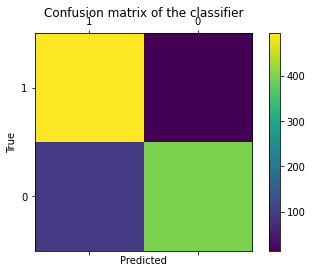

In [97]:
from sklearn.metrics import confusion_matrix
labels = [1, 0]
cm = confusion_matrix(y_list, predicted_labels, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Let's plot confusion matix over the test results:

In [98]:
#from ds_utils.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(y_test, predicted_labels, [1, 0])
#labels=['yes', 'no']
#plot_confusion_matrix(y_list, predicted_labels, labels)
#pyplot.show()

# Saving the Fine-Tuned Model


In [99]:
from pathlib import Path



output_dir = Path("__file__").parents[0].absolute().joinpath("model_save")
output_dir.mkdir(exist_ok=True)

model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(str(output_dir.absolute()))

('/content/model_save/vocab.txt',
 '/content/model_save/special_tokens_map.json',
 '/content/model_save/added_tokens.json')

In [100]:
import sklearn
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
precision = precision_score(y_test, predicted_labels, average='binary')
print('Precision: %.3f' % precision)

Precision: 0.838


In [101]:
recall = recall_score(y_test, predicted_labels, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.972


In [102]:
score = f1_score(y_test, predicted_labels, average='binary')
print('F-Measure: %.3f' % score)

F-Measure: 0.900
